# Heart Sounds Classification (Minimal Tutorial)

This notebook gives a gentle, end‑to‑end walkthrough:
1. Load metadata & inspect a few rows
2. Visualize a waveform and log‑mel spectrogram
3. Extract very simple features (mean log‑mel energies + a few signal stats)
4. Train/test split
5. Train a Logistic Regression classifier
6. Evaluate performance & run a single prediction

Everything is intentionally small & readable; you can scale it up later.

## Dataset Source
We start directly from the raw PhysioNet-style CSV metadata files `set_a.csv` and `set_b.csv`, plus their corresponding audio folders `set_a/` and `set_b/`.

Each CSV row references a `.wav` file found in the respective folder. We'll:
- Read both CSVs
- Add a column with the full file path
- Concatenate and keep only rows whose audio file actually exists
- Proceed with visualization, feature extraction, and classification.

In [17]:
# 1. Load raw CSV metadata and build file paths (robust version)
import pandas as pd, os
from pathlib import Path

set_a_csv = DATA_ROOT / 'set_a.csv'
set_b_csv = DATA_ROOT / 'set_b.csv'

set_a = pd.read_csv(set_a_csv)
set_b = pd.read_csv(set_b_csv)
print('Set A rows:', len(set_a), 'Set B rows:', len(set_b))

# Identify filename column (prefer 'fname')
preferred_cols = [c for c in set_a.columns if c.lower() == 'fname']
if preferred_cols:
    fname_col = preferred_cols[0]
else:
    possible_cols = [c for c in set_a.columns if 'fname' in c.lower() or 'file' in c.lower()]
    fname_col = possible_cols[0] if possible_cols else set_a.columns[0]
print('Using file name column:', fname_col)

# Identify label column
label_col_candidates = [c for c in set_a.columns if 'label' in c.lower() or 'class' in c.lower()]
label_col = label_col_candidates[0] if label_col_candidates else (set_a.columns[1] if len(set_a.columns) > 1 else fname_col)
print('Using label column:', label_col)

ACCEPT_LABELS = {'normal','murmur','artifact'}  # ignore unlabeled / extras

# Normalise helper
def normalise_label(x: str) -> str:
    x = str(x).strip().lower()
    # Many raw files may have 'normal', 'murmur', 'artifact', possibly other tags.
    return x

# Build a unified cleaner

def prepare(df: pd.DataFrame, origin: str) -> pd.DataFrame:
    out = df.copy()
    out['split_origin'] = origin
    # Ensure extension
    out[fname_col] = out[fname_col].astype(str).str.replace('.wav','', regex=False) + '.wav'
    out['raw_fname'] = out[fname_col]
    # First candidate: root / raw_fname (works if raw contains 'set_a/xyz.wav')
    cand1 = out['raw_fname'].apply(lambda s: DATA_ROOT / s)
    # Second candidate: root / origin / raw_fname (works if raw fname is only the basename)
    cand2 = out['raw_fname'].apply(lambda s: DATA_ROOT / origin / s)
    # Decide which exists; fallback to cand2
    def pick(p1, p2):
        return p1 if p1.is_file() else p2
    out['full_path'] = [str(pick(p1, p2)) for p1, p2 in zip(cand1, cand2)]
    # Label clean
    out['label'] = out[label_col].map(normalise_label)
    out = out[out['label'].isin(ACCEPT_LABELS)]
    return out[['raw_fname','full_path','label','split_origin']]

prep_a = prepare(set_a, 'set_a')
prep_b = prepare(set_b, 'set_b')
meta_raw = pd.concat([prep_a, prep_b], ignore_index=True)

meta_raw['exists'] = meta_raw['full_path'].apply(lambda p: os.path.isfile(p))
missing = (~meta_raw['exists']).sum()
print(f'Total rows after label filter: {len(meta_raw)} | Missing files: {missing}')
if missing and missing < 10:
    print('Missing sample paths:')
    display(meta_raw.loc[~meta_raw['exists'], 'full_path'].head())

meta = meta_raw[meta_raw['exists']].drop(columns=['exists']).reset_index(drop=True)
print('Usable rows:', len(meta))
if len(meta) == 0:
    raise RuntimeError('No audio files found. Inspect path logic and file layout.')
meta.head()

Set A rows: 176 Set B rows: 656
Using file name column: fname
Using label column: label
Total rows after label filter: 520 | Missing files: 415
Usable rows: 105


,raw_fname,full_path,label,split_origin
0,set_a/artifact__201012172012.wav,..\data\set_a\artifact__201012172012.wav,artifact,set_a
1,set_a/artifact__201105040918.wav,..\data\set_a\artifact__201105040918.wav,artifact,set_a
2,set_a/artifact__201105041959.wav,..\data\set_a\artifact__201105041959.wav,artifact,set_a
3,set_a/artifact__201105051017.wav,..\data\set_a\artifact__201105051017.wav,artifact,set_a
4,set_a/artifact__201105060108.wav,..\data\set_a\artifact__201105060108.wav,artifact,set_a


Example label: artifact


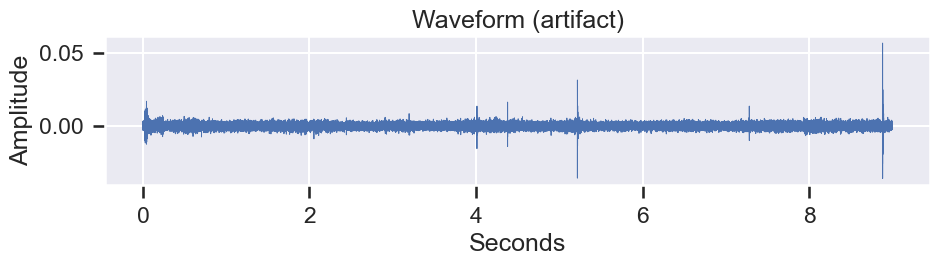

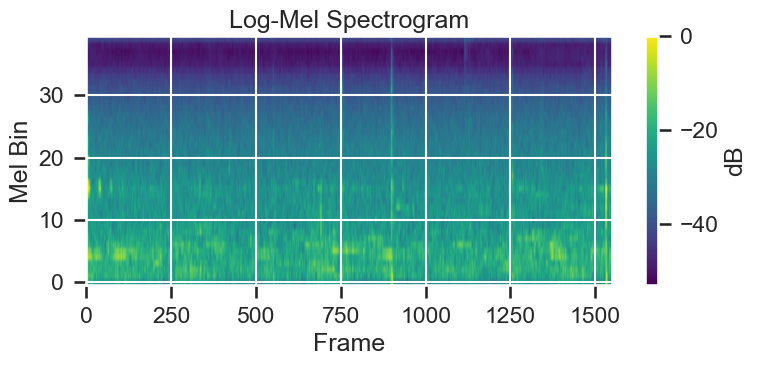

In [18]:
# 2. Visualize one example (waveform + log-mel)
example_row = meta.sample(random_state=RANDOM_SEED).iloc[0]
example_path = example_row.full_path
print('Example label:', example_row.label)

y, sr = lr.load(example_path, sr=TARGET_SR, mono=True)

t = np.arange(len(y)) / sr
plt.figure(figsize=(10,3))
plt.plot(t, y, lw=0.7)
plt.title(f'Waveform ({example_row.label})')
plt.xlabel('Seconds'); plt.ylabel('Amplitude')
plt.tight_layout(); plt.show()

mel = lr.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
mel_db = lr.power_to_db(mel, ref=np.max)
plt.figure(figsize=(8,4))
plt.imshow(mel_db, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='dB')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Frame'); plt.ylabel('Mel Bin')
plt.tight_layout(); plt.show()

In [19]:
# 3. Simple feature extraction function (mean log-mel + rms + zcr + duration)

def extract_simple_features(path: str | Path) -> dict:
    y, sr = lr.load(path, sr=TARGET_SR, mono=True)
    mel = lr.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
    mel_db = lr.power_to_db(mel, ref=np.max)
    mean_mel = mel_db.mean(axis=1)
    feats = {f'mean_logmel_{i}': float(v) for i, v in enumerate(mean_mel)}
    feats['rms'] = float(np.sqrt(np.mean(y**2))) if y.size else 0.0
    feats['zcr'] = float(((y[:-1] * y[1:]) < 0).sum() / (y.size - 1)) if y.size > 1 else 0.0
    feats['dur_sec'] = len(y)/sr
    return feats

# 4. Build feature table from raw files (optionally subsample for speed)
SAMPLE_SIZE = None  # set to e.g. 150 for a faster trial
subset = meta if SAMPLE_SIZE is None else meta.sample(SAMPLE_SIZE, random_state=RANDOM_SEED)

rows = []
for i, (_, row) in enumerate(subset.iterrows(), start=1):
    feats = extract_simple_features(row.full_path)
    feats['label'] = row.label
    rows.append(feats)
    if i % 25 == 0:
        print(f'Processed {i}/{len(subset)} files')

df_features = pd.DataFrame(rows)
print('Feature table shape:', df_features.shape)

y = df_features['label'].values
X = df_features.drop(columns=['label']).values
labels = sorted(np.unique(y))
label_to_idx = {lab:i for i, lab in enumerate(labels)}
y_idx = np.array([label_to_idx[v] for v in y])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_idx, test_size=0.3, stratify=y_idx, random_state=RANDOM_SEED)
X_train.shape, X_test.shape

Processed 25/105 files
Processed 50/105 files
Processed 50/105 files
Processed 75/105 files
Processed 75/105 files
Processed 100/105 files
Feature table shape: (105, 44)
Processed 100/105 files
Feature table shape: (105, 44)


((73, 43), (32, 43))

In [20]:
# 5. Train classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=RANDOM_SEED)
clf.fit(X_train_scaled, y_train)

pred_test = clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, pred_test))
print('Macro F1:', f1_score(y_test, pred_test, average='macro', zero_division=0))
print('\nClassification Report:\n')
print(classification_report(y_test, pred_test, target_names=labels, zero_division=0))

# 6. Single prediction
test_sample_idx = 0
sample_feat = X_test_scaled[test_sample_idx].reshape(1,-1)
inv_map = {v:k for k,v in label_to_idx.items()}
print('Predicted label:', inv_map[clf.predict(sample_feat)[0]])

Accuracy: 0.84375
Macro F1: 0.8394755003450656

Classification Report:

              precision    recall  f1-score   support

    artifact       1.00      0.92      0.96        12
      murmur       0.73      0.80      0.76        10
      normal       0.80      0.80      0.80        10

    accuracy                           0.84        32
   macro avg       0.84      0.84      0.84        32
weighted avg       0.85      0.84      0.85        32

Predicted label: normal


c:\Users\Michi\anaconda3\envs\sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
